In [1]:
import pandas as pd 
df = pd.read_csv("/kaggle/input/spl-preprocessed-reviews/spl_preprocessed_reviews_14_may_2025.csv")

In [2]:
df.head()

,review_text,sentiment,review_time,rating,app_name,cleaned_review,tokens,filtered_tokens,lemmatized,lang_type
0,not good not bad,Negative,2025-04-09 3:08:43,5,Agrani Smart Banking App,not good not bad,"['not', 'good', 'not', 'bad']","['not', 'good', 'not', 'bad']","['not', 'good', 'not', 'bad']",english
1,nice,Positive,2025-04-06 3:26:31,5,Agrani Smart Banking App,nice,['nice'],['nice'],['nice'],english
2,really helpful app nice working,Positive,2025-04-02 19:45:17,4,Agrani Smart Banking App,really helpful app nice working,"['really', 'helpful', 'app', 'nice', 'working']","['really', 'helpful', 'app', 'nice', 'working']","['really', 'helpful', 'app', 'nice', 'working']",english
3,good,Positive,2025-03-27 17:46:04,5,Agrani Smart Banking App,good,['good'],['good'],['good'],english
4,good.. job...,Positive,2025-03-27 7:57:25,3,Agrani Smart Banking App,good job,"['good', 'job']","['good', 'job']","['good', 'job']",english


In [3]:
df[df['sentiment'].notna()]['lang_type'].value_counts()

lang_type
english    1396
bangla      168
mixed        54
Name: count, dtype: int64

In [4]:
labeled_df = df[df['sentiment'].notna()]

In [5]:
labeled_df['sentiment'].value_counts()

sentiment
Negative    853
Positive    765
Name: count, dtype: int64

# Train-Test Split with Stratification

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Keep only labeled data
labeled_df = df[df['sentiment'].notna()].copy()

# Create stratification column
labeled_df['stratify_col'] = labeled_df['lang_type'].astype(str) + "_" + labeled_df['sentiment'].astype(str)

# Stratified split
train_df, test_df = train_test_split(
    labeled_df,
    test_size=0.2,
    stratify=labeled_df['stratify_col'],
    random_state=42
)

In [8]:
# Show absolute counts
print(" Full dataset distribution:")
print(labeled_df['stratify_col'].value_counts())

# Show proportions
print("\n Full dataset proportions:")
print(labeled_df['stratify_col'].value_counts(normalize=True))


 Full dataset distribution:
stratify_col
english_Positive    705
english_Negative    691
bangla_Negative     120
bangla_Positive      48
mixed_Negative       42
mixed_Positive       12
Name: count, dtype: int64

 Full dataset proportions:
stratify_col
english_Positive    0.435723
english_Negative    0.427070
bangla_Negative     0.074166
bangla_Positive     0.029666
mixed_Negative      0.025958
mixed_Positive      0.007417
Name: proportion, dtype: float64


# TF-IDF Feature Extraction for ML

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_df['processed_review'] = train_df['lemmatized'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)
test_df['processed_review'] = test_df['lemmatized'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)
# TF-IDF using word and character n-grams (you can tweak this)
tfidf = TfidfVectorizer(analyzer='char_wb', ngram_range=(1, 3), max_features=5000)

# Fit on training data
X_train_tfidf = tfidf.fit_transform(train_df['processed_review'])

# Transform test data
X_test_tfidf = tfidf.transform(test_df['cleaned_review'])

In [10]:
 X_train_tfidf.shape

(1294, 5000)

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_df['sentiment'])
y_test = le.transform(test_df['sentiment'])

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'Negative': 0, 'Positive': 1}


# SVM (Support Vector Machine) Model

In [12]:
# Initialize SVM model
svm_model = LinearSVC()

# Train the SVM model
svm_model.fit(X_train_tfidf, y_train)
print("SVM model trained.")

# Predict on test data
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation for SVM model
print("\n SVM Evaluation ")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


SVM model trained.

 SVM Evaluation 
Accuracy: 0.7993827160493827

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.67      0.78       171
           1       0.72      0.94      0.82       153

    accuracy                           0.80       324
   macro avg       0.82      0.81      0.80       324
weighted avg       0.83      0.80      0.80       324



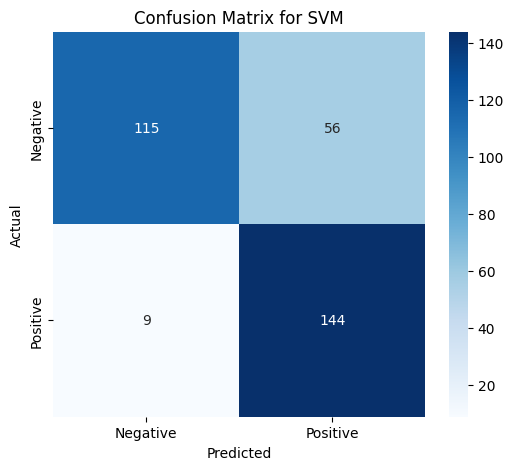

In [13]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for SVM")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Naive Bayes Model

In [14]:
# Initialize Naive Bayes model
nb_model = MultinomialNB()

# Train the Naive Bayes model
nb_model.fit(X_train_tfidf, y_train)
print("Naive Bayes model trained.")

# Predict on test data
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluation for Naive Bayes model
print("\n Naive Bayes Evaluation ")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes model trained.

 Naive Bayes Evaluation 
Accuracy: 0.8919753086419753

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.95      0.90       171
           1       0.93      0.83      0.88       153

    accuracy                           0.89       324
   macro avg       0.90      0.89      0.89       324
weighted avg       0.90      0.89      0.89       324



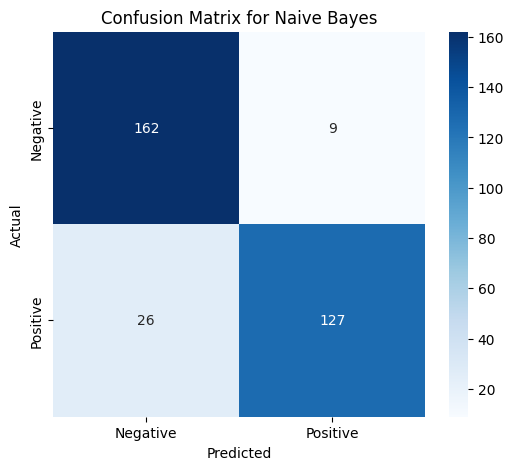

In [15]:
# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Naive Bayes")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Decision Tree Model

In [16]:
# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt_model.fit(X_train_tfidf, y_train)
print("Decision Tree model trained.")

# Predict on test data
y_pred_dt = dt_model.predict(X_test_tfidf)

# Evaluation for Decision Tree model
print("\n Decision Tree Evaluation ")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree model trained.

 Decision Tree Evaluation 
Accuracy: 0.4660493827160494

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.11      0.17       171
           1       0.47      0.87      0.61       153

    accuracy                           0.47       324
   macro avg       0.47      0.49      0.39       324
weighted avg       0.47      0.47      0.38       324



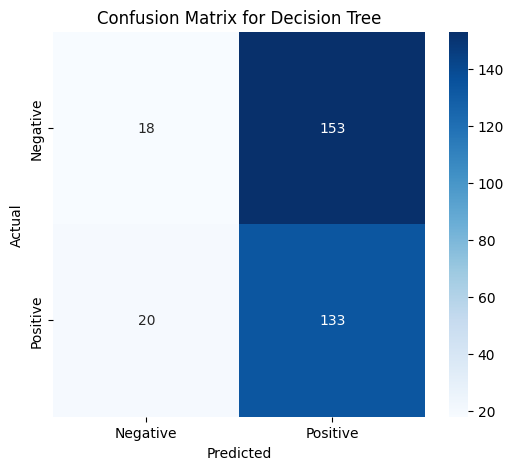

In [17]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Decision Tree")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# Logistic Regression Model

In [18]:
from sklearn.linear_model import LogisticRegression
# Initialize Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the Logistic Regression model
logreg_model.fit(X_train_tfidf, y_train)
print("Logistic Regression model trained.")

# Predict on test data
y_pred_logreg = logreg_model.predict(X_test_tfidf)

# Evaluation for Logistic Regression model
print("\n Logistic Regression Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))


Logistic Regression model trained.

 Logistic Regression Evaluation
Accuracy: 0.7901234567901234

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.64      0.76       171
           1       0.71      0.95      0.81       153

    accuracy                           0.79       324
   macro avg       0.82      0.80      0.79       324
weighted avg       0.83      0.79      0.79       324



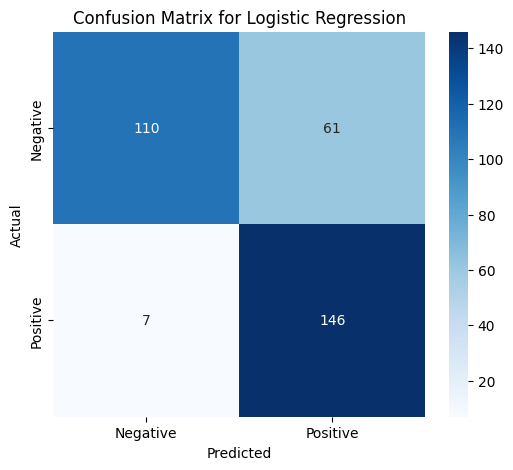

In [19]:
# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Random Forest Model

In [20]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_tfidf, y_train)
print("Random Forest model trained.")

# Predict on test data
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation for Random Forest model
print("\n Random Forest Evaluation")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest model trained.

 Random Forest Evaluation
Accuracy: 0.8765432098765432

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       171
           1       0.86      0.88      0.87       153

    accuracy                           0.88       324
   macro avg       0.88      0.88      0.88       324
weighted avg       0.88      0.88      0.88       324



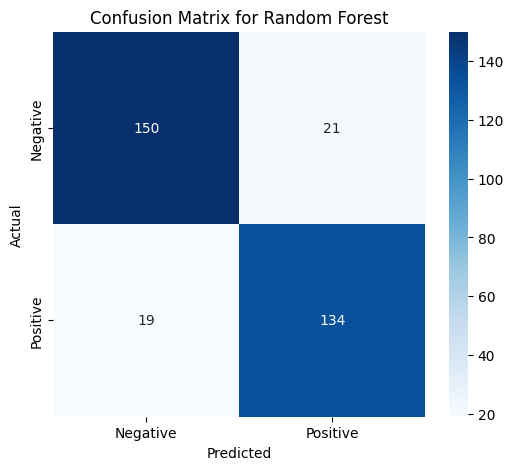

In [21]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for Random Forest")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()